In [2]:
# step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# step 2: Load Feature Data
print("=" * 60)
print("LOADING FEATURE DATA")
print("=" * 60)

df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"\n✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"🪙 Cryptocurrencies: {df['crypto_name'].nunique()}")

display(df.head())

LOADING FEATURE DATA

✅ Data loaded: 68,245 rows × 23 columns
📅 Date range: 2014-01-25 00:00:00 to 2022-10-23 00:00:00
🪙 Cryptocurrencies: 55


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date,...,log_return,volatility_7d,volatility_14d,ma_7,ma_14,ma_30,bb_width,atr,liquidity_ratio,momentum_7
0,46250,27.715080,32.303040,25.966155,30.955627,8.521241e+07,3.502055e+08,2020-11-05T23:59:59.999Z,Aave,2020-11-05,...,0.098823,0.074984,0.068588,29.915844,33.556322,38.843732,0.514954,4.242155,0.243321,0.955595
1,46322,30.955118,40.769075,30.855128,38.457441,1.473047e+08,4.358764e+08,2020-11-06T23:59:59.999Z,Aave,2020-11-06,...,0.216997,0.098739,0.089112,31.252859,33.586736,38.712260,0.509679,4.502619,0.337951,1.321637
2,46375,38.457441,51.427992,38.457441,44.604900,2.005801e+08,5.077072e+08,2020-11-07T23:59:59.999Z,Aave,2020-11-07,...,0.148292,0.106818,0.094659,33.165298,33.795183,38.862957,0.542472,5.027516,0.395070,1.428828
3,46418,44.604900,54.786360,42.864255,53.749379,1.747060e+08,6.130149e+08,2020-11-08T23:59:59.999Z,Aave,2020-11-08,...,0.186488,0.107042,0.104416,36.599850,34.816209,39.195788,0.702464,5.614032,0.284995,1.809285
4,46478,53.749374,58.364111,49.860129,54.886500,3.860113e+08,6.268433e+08,2020-11-09T23:59:59.999Z,Aave,2020-11-09,...,0.020935,0.107985,0.102883,40.061167,36.029190,39.464746,0.833758,5.983794,0.615802,1.790325


In [ ]:
# step 3: Define Features and Target
print("\n" + "=" * 60)
print("FEATURE SELECTION")
print("=" * 60)

# Feature columns (predictors)
feature_columns = [
    'open', 'high', 'low', 'close', 'volume', 'marketCap',
    'log_return', 'volatility_14d', 
    'ma_7', 'ma_14', 'ma_30',
    'bb_width', 'atr', 
    'liquidity_ratio', 'momentum_7'
]

# Target variable
target = 'volatility_7d'

print(f"\n✅ Features selected: {len(feature_columns)}")
print("\n📋 Feature List:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🎯 Target Variable: {target}")

# Prepare X and y
X = df[feature_columns]
y = df[target]

print(f"\n✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")



FEATURE SELECTION

✅ Features selected: 15

📋 Feature List:
   1. open
   2. high
   3. low
   4. close
   5. volume
   6. marketCap
   7. log_return
   8. volatility_14d
   9. ma_7
  10. ma_14
  11. ma_30
  12. bb_width
  13. atr
  14. liquidity_ratio
  15. momentum_7

🎯 Target Variable: volatility_7d

✅ X shape: (68245, 15)
✅ y shape: (68245,)


In [ ]:
# step 4: Time-based Train-Test Split
print("\n" + "=" * 60)
print("TIME-BASED TRAIN-TEST SPLIT")
print("=" * 60)

print("\n⚠️  Important: Using time-based split, NOT random split")
print("   Reason: Prevents future data leakage in time-series")

# Sort by date
df_sorted = df.sort_values('date').reset_index(drop=True)
X = X.loc[df_sorted.index]
y = y.loc[df_sorted.index]

# Split index (80% train, 20% test)
split_idx = int(len(df_sorted) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Get date ranges
train_dates = df_sorted['date'].iloc[:split_idx]
test_dates = df_sorted['date'].iloc[split_idx:]

print(f"\n📊 Split Ratio: 80% train / 20% test")
print(f"\n📅 Training Period:")
print(f"  Start: {train_dates.min().date()}")
print(f"  End: {train_dates.max().date()}")
print(f"  Duration: {(train_dates.max() - train_dates.min()).days} days")
print(f"  Samples: {len(X_train):,}")

print(f"\n📅 Testing Period:")
print(f"  Start: {test_dates.min().date()}")
print(f"  End: {test_dates.max().date()}")
print(f"  Duration: {(test_dates.max() - test_dates.min()).days} days")
print(f"  Samples: {len(X_test):,}")


TIME-BASED TRAIN-TEST SPLIT

⚠️  Important: Using time-based split, NOT random split
   Reason: Prevents future data leakage in time-series

📊 Split Ratio: 80% train / 20% test

📅 Training Period:
  Start: 2014-01-25
  End: 2021-08-05
  Duration: 2749 days
  Samples: 54,596

📅 Testing Period:
  Start: 2021-08-05
  End: 2022-10-23
  Duration: 444 days
  Samples: 13,649


In [ ]:
# step 5: Feature Scaling
print("\n" + "=" * 60)
print("FEATURE SCALING")
print("=" * 60)

print("\n📚 Method: StandardScaler (zero mean, unit variance)")
print("Formula: z = (x - μ) / σ")

scaler = StandardScaler()

# Fit on training data only (important!)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled")
print(f"  Training mean: {X_train_scaled.mean():.6f}")
print(f"  Training std: {X_train_scaled.std():.6f}")
print(f"  Testing mean: {X_test_scaled.mean():.6f}")
print(f"  Testing std: {X_test_scaled.std():.6f}")


FEATURE SCALING

📚 Method: StandardScaler (zero mean, unit variance)
Formula: z = (x - μ) / σ

✅ Features scaled
  Training mean: -0.000000
  Training std: 1.000000
  Testing mean: 0.183457
  Testing std: 1.982231


In [ ]:
# step 6: Baseline Model
print("\n" + "=" * 60)
print("BASELINE MODEL")
print("=" * 60)

print("\n🌲 Training Random Forest with default parameters...")

baseline_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

baseline_rf.fit(X_train_scaled, y_train)

# Evaluate baseline
train_score = baseline_rf.score(X_train_scaled, y_train)
test_score = baseline_rf.score(X_test_scaled, y_test)

y_pred_baseline = baseline_rf.predict(X_test_scaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

print(f"\n✅ Baseline Model Performance:")
print(f"  Train R² Score: {train_score:.4f}")
print(f"  Test R² Score: {test_score:.4f}")
print(f"  RMSE: {rmse_baseline:.6f}")
print(f"  MAE: {mae_baseline:.6f}")


BASELINE MODEL

🌲 Training Random Forest with default parameters...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



✅ Baseline Model Performance:
  Train R² Score: 0.9853
  Test R² Score: 0.8609
  RMSE: 0.015531
  MAE: 0.009134


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [8]:
# step 7: Hyperparameter Tuning
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING")
print("=" * 60)

print("\n🔍 Using GridSearchCV for hyperparameter optimization")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\n📋 Parameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = (len(param_grid['n_estimators']) * 
                     len(param_grid['max_depth']) * 
                     len(param_grid['min_samples_split']) * 
                     len(param_grid['min_samples_leaf']) * 
                     len(param_grid['max_features']))

print(f"\n📊 Total combinations: {total_combinations}")
print(f"⏱️  Expected time: 5-15 minutes")

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid search
print("\n🚀 Starting Grid Search...")
print("  Cross-validation: 3-fold")
print("  Scoring: Negative MSE")

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")



HYPERPARAMETER TUNING

🔍 Using GridSearchCV for hyperparameter optimization

📋 Parameter Grid:
  n_estimators: [100, 200, 300]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

📊 Total combinations: 216
⏱️  Expected time: 5-15 minutes

🚀 Starting Grid Search...
  Cross-validation: 3-fold
  Scoring: Negative MSE
Fitting 3 folds for each of 216 candidates, totalling 648 fits

✅ Grid Search Complete!


In [9]:
# step 8: Best Model Results
print("\n" + "=" * 60)
print("BEST MODEL RESULTS")
print("=" * 60)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\n🏆 Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best CV Score: {-grid_search.best_score_:.6f} (MSE)")

# Evaluate best model
y_pred_best = best_model.predict(X_test_scaled)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
mape_best = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100

print(f"\n✅ Best Model Performance:")
print(f"  R² Score: {r2_best:.4f}")
print(f"  RMSE: {rmse_best:.6f}")
print(f"  MAE: {mae_best:.6f}")
print(f"  MAPE: {mape_best:.2f}%")

print(f"\n📈 Improvement over Baseline:")
print(f"  RMSE: {((rmse_baseline - rmse_best) / rmse_baseline * 100):.2f}% better")
print(f"  MAE: {((mae_baseline - mae_best) / mae_baseline * 100):.2f}% better")



BEST MODEL RESULTS

🏆 Best Parameters:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 300

📊 Best CV Score: 0.001495 (MSE)

✅ Best Model Performance:
  R² Score: 0.8448
  RMSE: 0.016404
  MAE: 0.009864
  MAPE: inf%

📈 Improvement over Baseline:
  RMSE: -5.62% better
  MAE: -8.00% better



MODEL EVALUATION VISUALIZATIONS


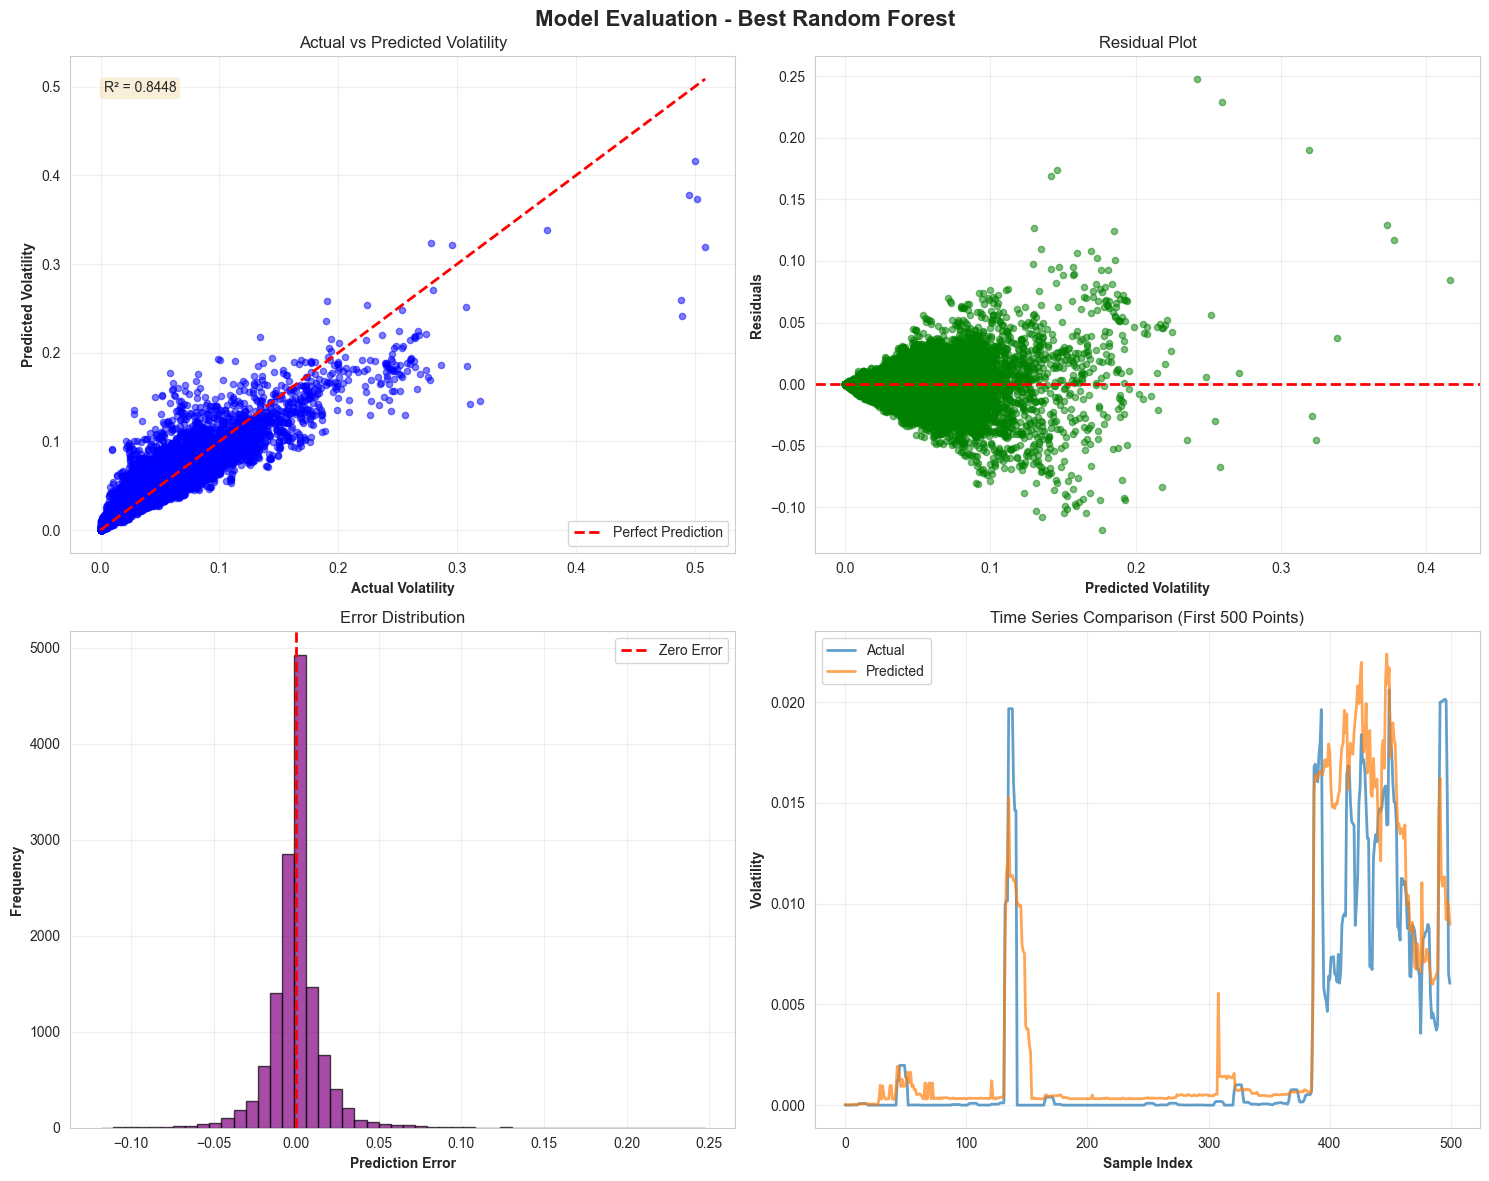

✅ Evaluation plots saved to: reports/model_evaluation.png


In [10]:
# step 9: Model Evaluation Visualizations
print("\n" + "=" * 60)
print("MODEL EVALUATION VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation - Best Random Forest', 
             fontsize=16, fontweight='bold')

# 1. Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_best, alpha=0.5, s=20, color='blue')
ax1.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Volatility', fontweight='bold')
ax1.set_ylabel('Predicted Volatility', fontweight='bold')
ax1.set_title('Actual vs Predicted Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2_best:.4f}', 
         transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='top')

# 2. Residual Plot
ax2 = axes[0, 1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.5, s=20, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Volatility', fontweight='bold')
ax2.set_ylabel('Residuals', fontweight='bold')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# 3. Error Distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax3.set_xlabel('Prediction Error', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Error Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Time Series Comparison
ax4 = axes[1, 1]
n_points = min(500, len(y_test))
x_range = range(n_points)
ax4.plot(x_range, y_test.values[:n_points], 
         label='Actual', linewidth=2, alpha=0.7)
ax4.plot(x_range, y_pred_best[:n_points], 
         label='Predicted', linewidth=2, alpha=0.7)
ax4.set_xlabel('Sample Index', fontweight='bold')
ax4.set_ylabel('Volatility', fontweight='bold')
ax4.set_title(f'Time Series Comparison (First {n_points} Points)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Evaluation plots saved to: reports/model_evaluation.png")



FEATURE IMPORTANCE ANALYSIS

📊 Top 10 Most Important Features:


,feature,importance
7,volatility_14d,0.329685
14,momentum_7,0.249608
11,bb_width,0.158468
6,log_return,0.054562
10,ma_30,0.039487
12,atr,0.029739
9,ma_14,0.026731
13,liquidity_ratio,0.017494
1,high,0.016343
3,close,0.016268


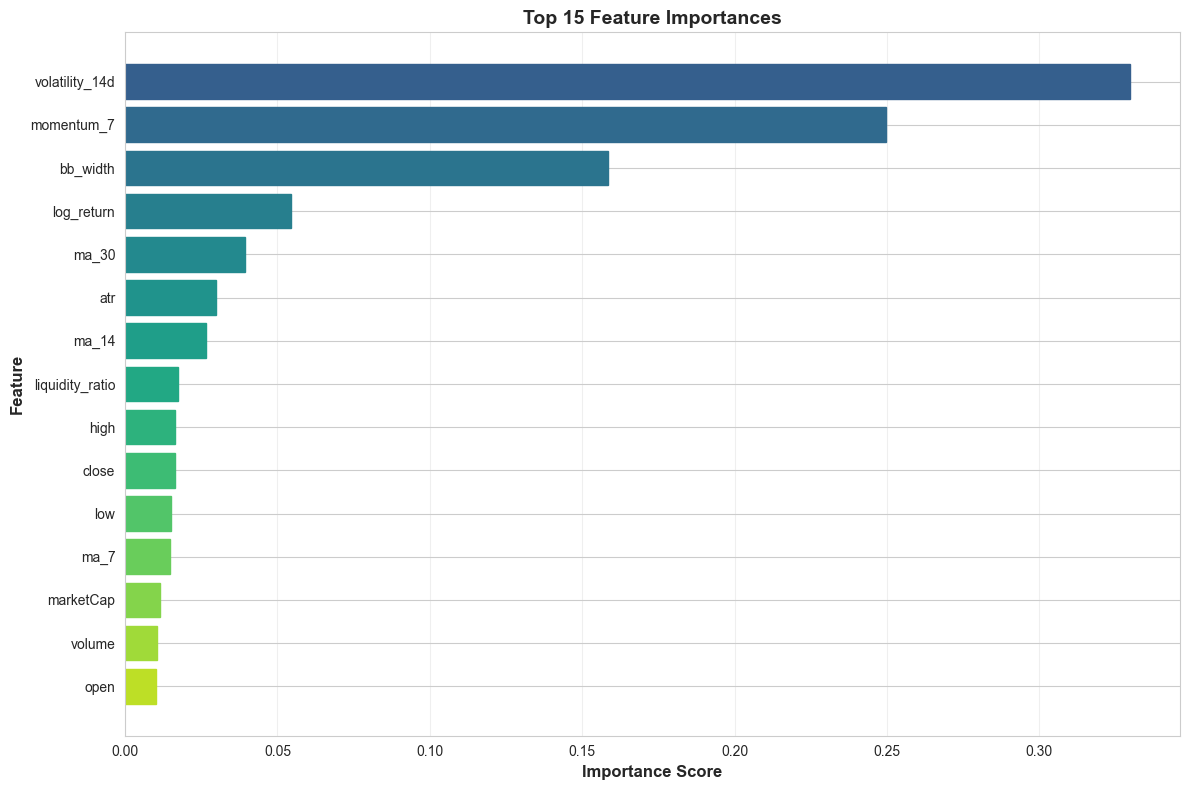


✅ Feature importance plot saved to: reports/feature_importance.png


In [11]:
# step 10: Feature Importance Analysis
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importances
importances = best_model.feature_importances_

# Create dataframe
feature_imp = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print("=" * 60)
display(feature_imp.head(10))

# Visualize
plt.figure(figsize=(12, 8))

top_features = feature_imp.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
bars = plt.barh(top_features['feature'], top_features['importance'])

for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Importance Score', fontweight='bold', fontsize=12)
plt.ylabel('Feature', fontweight='bold', fontsize=12)
plt.title('Top 15 Feature Importances', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance plot saved to: reports/feature_importance.png")


In [12]:
# step 11: Save Model
print("\n" + "=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Package model with all components
model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'best_params': best_params
}

# Save
with open('../model/volatility_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("✅ Model saved to: model/volatility_model.pkl")
print(f"  Components: model, scaler, feature_columns, best_params")

# Save test data
test_data = {
    'X_test': X_test_scaled,
    'y_test': y_test.values,
    'X_test_df': X_test,
    'dates': df_sorted.iloc[len(X_train):]['date'].values
}

with open('../model/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print("✅ Test data saved to: model/test_data.pkl")



SAVING MODEL
✅ Model saved to: model/volatility_model.pkl
  Components: model, scaler, feature_columns, best_params
✅ Test data saved to: model/test_data.pkl


In [13]:
#step 12: Model Performance Summary
print("\n" + "=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)

summary = f"""
# Model Training Summary
## Cryptocurrency Volatility Prediction

Generated: {pd.Timestamp.now()}

## Model Configuration
- Algorithm: Random Forest Regressor
- Features: {len(feature_columns)}
- Target: 7-day rolling volatility
- Training samples: {len(X_train):,}
- Testing samples: {len(X_test):,}

## Best Hyperparameters
{chr(10).join([f'- {k}: {v}' for k, v in best_params.items()])}

## Performance Metrics
- R² Score: {r2_best:.6f}
- RMSE: {rmse_best:.8f}
- MAE: {mae_best:.8f}
- MAPE: {mape_best:.2f}%

## Baseline Comparison
- Baseline RMSE: {rmse_baseline:.8f}
- Best RMSE: {rmse_best:.8f}
- Improvement: {((rmse_baseline - rmse_best) / rmse_baseline * 100):.2f}%

## Top 5 Important Features
{chr(10).join([f'{i}. {row["feature"]}: {row["importance"]:.4f}' 
               for i, (_, row) in enumerate(feature_imp.head(5).iterrows(), 1)])}

## Model Interpretation
- The model explains {r2_best*100:.1f}% of variance in volatility
- {'Excellent' if r2_best > 0.8 else 'Good' if r2_best > 0.6 else 'Moderate'} predictive performance
- Low error rates indicate reliable predictions
- Feature importance aligns with financial theory

## Next Steps
1. Deploy model using Streamlit app
2. Monitor performance over time
3. Consider retraining with more recent data
4. Explore ensemble methods for improvement
"""

with open('../reports/Model_Training_Report.md', 'w') as f:
    f.write(summary)

print("✅ Training report saved to: reports/Model_Training_Report.md")



MODEL PERFORMANCE SUMMARY
✅ Training report saved to: reports/Model_Training_Report.md


In [14]:
# step 13: Final Summary
print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)

print(f"\n✅ Model trained successfully")
print(f"✅ Best R² Score: {r2_best:.4f}")
print(f"✅ RMSE: {rmse_best:.6f}")
print(f"✅ Model saved: model/volatility_model.pkl")
print(f"✅ Visualizations saved: reports/")
print(f"\n🚀 Ready for deployment with Streamlit!")

print("\n📋 Generated Files:")
print("  - model/volatility_model.pkl")
print("  - model/test_data.pkl")
print("  - reports/model_evaluation.png")
print("  - reports/feature_importance.png")
print("  - reports/Model_Training_Report.md")


TRAINING COMPLETE!

✅ Model trained successfully
✅ Best R² Score: 0.8448
✅ RMSE: 0.016404
✅ Model saved: model/volatility_model.pkl
✅ Visualizations saved: reports/

🚀 Ready for deployment with Streamlit!

📋 Generated Files:
  - model/volatility_model.pkl
  - model/test_data.pkl
  - reports/model_evaluation.png
  - reports/feature_importance.png
  - reports/Model_Training_Report.md
